# model_evaluation_and_training_curves.ipynb

**Project**: Lumbar Spine Degenerative Classification  
**Description**: This notebook loads the training log from a model folder to plot training/validation loss and accuracy curves, and then evaluates the best model saved in `best_model.pth`.

---

## Table of Contents
1. [Environment and Imports](#section1)  
2. [Define Model Folder and Parse Parameters](#section2)  
3. [Plot Training Curves](#section3)  
4. [Evaluate the Best Model](#section4)


<a id="section1"></a>
## 1. Environment and Imports

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import yaml

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

print("Current working directory:", os.getcwd())

Current working directory: /home/jkskw/git/ml_lumbar_mri


<a id="section2"></a>
## 2. Define Model Folder and Parse Parameters

In [22]:
def parse_model_folder_params(folder_name):
    """
    Parse training parameters from the model folder name.

    Expected folder name formats:
      For target window:
        {model_arch}_{...}_{classification_mode}_{tensor_type}_{resolution}_{depth}_{extra}_{batch_size}_{num_epochs}_{learning_rate}_{dropout}_{date}_{time}
      For full series:
        {model_arch}_{...}_{classification_mode}_{tensor_type}_{resolution}_{depth}_{batch_size}_{num_epochs}_{learning_rate}_{dropout}_{date}_{time}

    This function uses rsplit to extract the last fixed parameters, then splits the remaining prefix.
    It searches for a two-token sequence (joined with '_') that is one of:
        "single_multiclass", "single_binary", "multi_multiclass", "multi_binary"
    and then extracts:
      - model_arch: everything before the classification mode tokens (joined with '_')
      - classification_mode: the matched two tokens joined by '_'
      - selected_tensor_folder: built from the next tokens (tensor_type, resolution, depth, and optionally extra)
      - batch_size, num_epochs, learning_rate, dropout as numeric parameters.
    """
    # Split from the right into 7 parts:
    try:
        prefix, batch_size_str, num_epochs_str, learning_rate_str, dropout_str, _, _ = folder_name.rsplit("_", 6)
    except Exception as e:
        raise ValueError("Error splitting folder name (right-split): " + str(e))
    
    try:
        batch_size = int(batch_size_str)
        num_epochs = int(num_epochs_str)
        learning_rate = float(learning_rate_str)
        dropout = float(dropout_str)
    except Exception as e:
        raise ValueError("Error parsing numeric parameters from folder name: " + str(e))
    
    # Now split the prefix into tokens (the left-hand side may contain underscores in the model_arch)
    tokens = prefix.split("_")
    possible_class_modes = {"single_multiclass", "single_binary", "multi_multiclass", "multi_binary"}
    classification_mode = None
    model_arch = None
    tensor_type = None
    resolution = None
    depth = None
    extra = ""
    
    # Search for a two-token sequence that matches one of the classification modes.
    for i in range(1, len(tokens)-1):
        candidate = tokens[i] + "_" + tokens[i+1]
        if candidate in possible_class_modes:
            model_arch = "_".join(tokens[:i])
            classification_mode = candidate
            # The remaining tokens after the classification mode
            remaining = tokens[i+2:]
            # We assume at least 3 tokens remain:
            # For target window: usually [tensor_type, resolution, depth, extra]
            # For full series: usually [tensor_type, resolution, depth]
            if len(remaining) < 3:
                raise ValueError("Not enough tokens remaining for tensor type, resolution, and depth.")
            # If the next token contains "target" or "full", then we assume tensor_type is that token (or joined with the next one)
            # Here we simply join the next tokens if there are at least 2 tokens and if the second token is not numeric.
            if not remaining[1].replace("x", "").isdigit():
                tensor_type = "_".join(remaining[:2])
                resolution = remaining[2]
                if len(remaining) >= 4:
                    depth = remaining[3]
                else:
                    raise ValueError("Not enough tokens for depth in folder name.")
                if len(remaining) >= 5:
                    extra = remaining[4]
            else:
                tensor_type = remaining[0]
                resolution = remaining[1]
                depth = remaining[2]
            break

    if classification_mode is None:
        raise ValueError("Could not parse classification mode from folder name.")
    
    return {
        "model_arch": model_arch,
        "classification_mode": classification_mode,
        "selected_tensor_folder": f"{tensor_type}_{resolution}_{depth}" + (f"_{extra}" if extra else ""),
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "dropout": dropout,
    }

In [23]:
# Define the model folder path
MODEL_FOLDER = "models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507"

# Check if the folder exists
if os.path.exists(MODEL_FOLDER):
    print("Model folder found:", MODEL_FOLDER)
else:
    raise FileNotFoundError(f"Model folder not found: {MODEL_FOLDER}")

# Extract parameters from the folder name
folder_params = parse_model_folder_params(os.path.basename(MODEL_FOLDER))
print("Extracted parameters from folder name:")
for key, value in folder_params.items():
    print(f"  {key}: {value}")

Model folder found: models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507
Extracted parameters from folder name:
  model_arch: resnet3d_18
  classification_mode: multi_binary
  selected_tensor_folder: target_window_128x128_5D_B2A2
  batch_size: 16
  num_epochs: 10
  learning_rate: 0.001
  dropout: 0.5


<a id="section3"></a>
## 3. Plot Training Curves
- Training and Validation Loss  
- Training and Validation Accuracy

Training log shape: (10, 5)


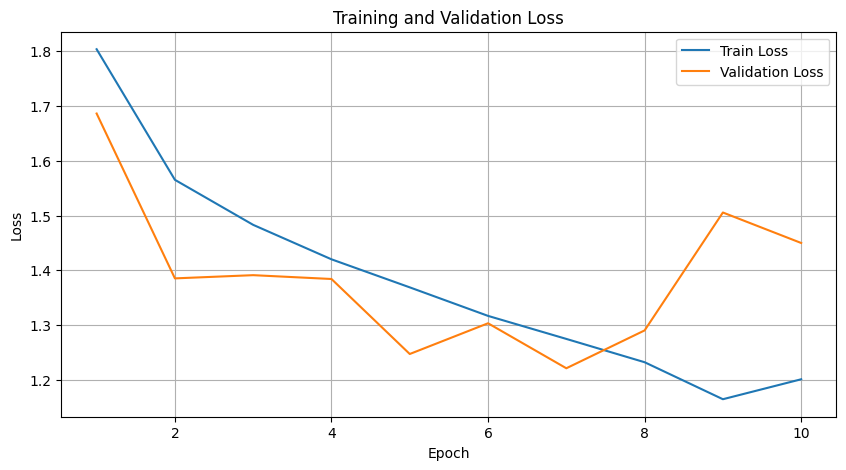

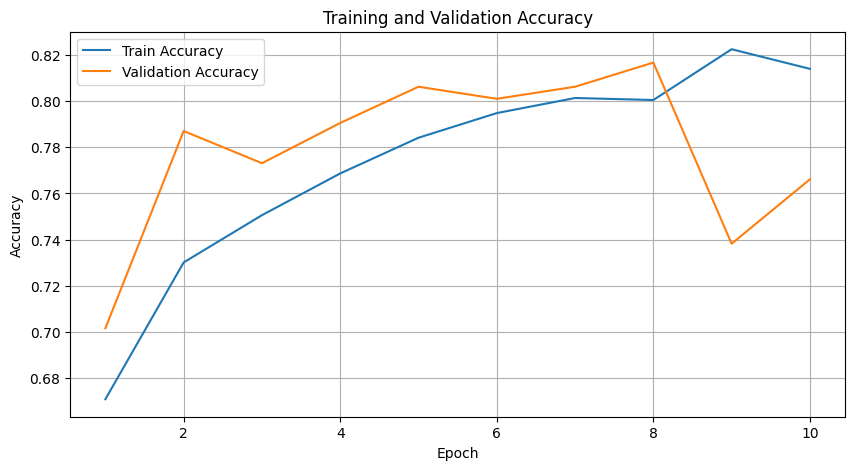

In [24]:
# Define the path to the training_log.csv file
log_csv_path = os.path.join(MODEL_FOLDER, "training_log.csv")

# Load the CSV file
df_log = pd.read_csv(log_csv_path)
print("Training log shape:", df_log.shape)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(df_log["epoch"], df_log["train_loss"], label="Train Loss")
plt.plot(df_log["epoch"], df_log["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df_log["epoch"], df_log["train_acc"], label="Train Accuracy")
plt.plot(df_log["epoch"], df_log["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


<a id="section4"></a>
## 4. Evaluate the Best Model

Temporary config file created at: /tmp/temp_config.yml
Best model found: models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507/best_model.pth
[INFO] Loading model from models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507/best_model.pth using arch=resnet3d_18


Evaluating on test set:   0%|          | 0/13 [00:00<?, ?it/s]

[INFO] Evaluation Completed.

=== Metrics for SCS ===
Accuracy: 0.9101
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       143
         1.0       0.85      0.76      0.80        46

    accuracy                           0.91       189
   macro avg       0.89      0.86      0.87       189
weighted avg       0.91      0.91      0.91       189

Confusion Matrix:
 [[137   6]
 [ 11  35]] 



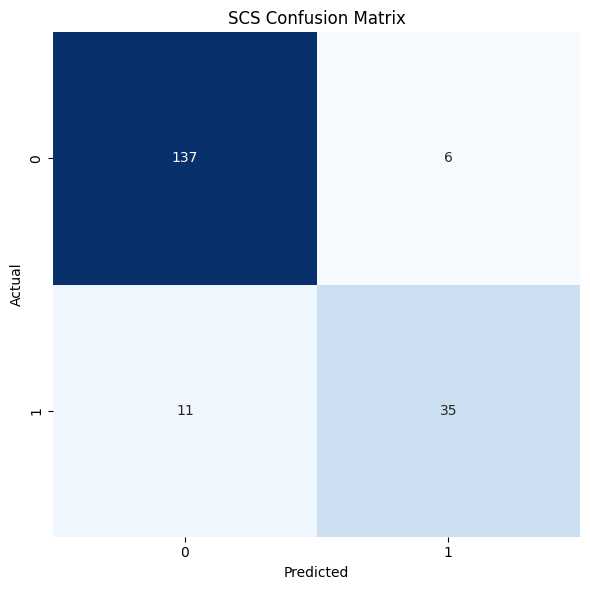

=== Metrics for LNfN ===
Accuracy: 0.7778
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.91      0.83       115
         1.0       0.81      0.57      0.67        74

    accuracy                           0.78       189
   macro avg       0.79      0.74      0.75       189
weighted avg       0.78      0.78      0.77       189

Confusion Matrix:
 [[105  10]
 [ 32  42]] 



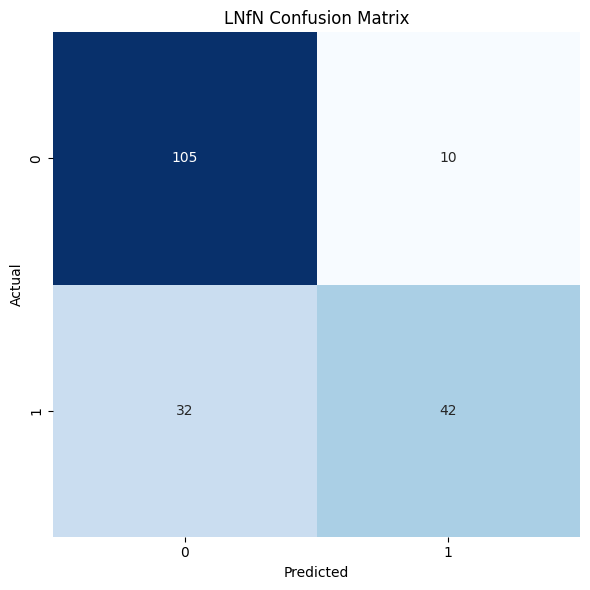

=== Metrics for RNfN ===
Accuracy: 0.8148
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       117
         1.0       0.84      0.64      0.72        72

    accuracy                           0.81       189
   macro avg       0.82      0.78      0.79       189
weighted avg       0.82      0.81      0.81       189

Confusion Matrix:
 [[108   9]
 [ 26  46]] 



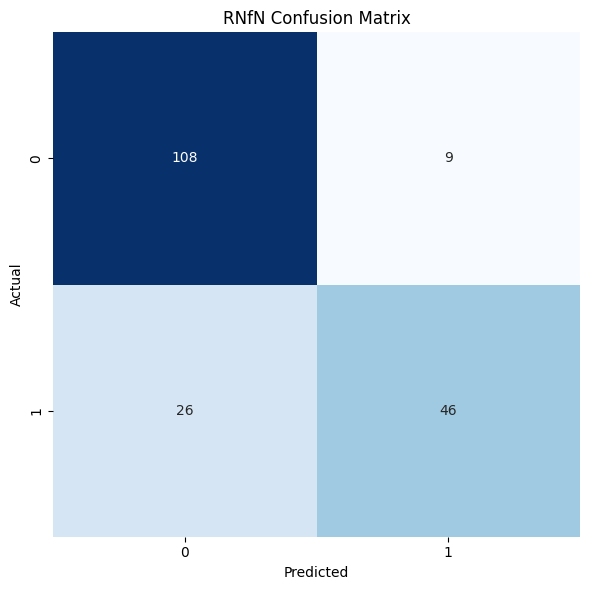

Temporary config file removed.


In [25]:
import tempfile

# Load the default configuration from 'config.yml'
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

# Update the training parameters using the extracted folder parameters
config["training"]["model_arch"] = folder_params["model_arch"]
config["training"]["classification_mode"] = folder_params["classification_mode"]
config["training"]["selected_tensor_folder"] = folder_params["selected_tensor_folder"]
config["training"]["batch_size"] = folder_params["batch_size"]
config["training"]["num_epochs"] = folder_params["num_epochs"]
config["training"]["learning_rate"] = folder_params["learning_rate"]

# Save the updated configuration to a temporary file (so original config.yml is not modified)
temp_config_path = os.path.join(tempfile.gettempdir(), "temp_config.yml")
with open(temp_config_path, "w") as f:
    yaml.dump(config, f, default_flow_style=False)
print("Temporary config file created at:", temp_config_path)

# Define the path to the best model file
best_model_path = os.path.join(MODEL_FOLDER, "best_model.pth") # or best_val_loss_model.pth / "best_model.pth"
if os.path.exists(best_model_path):
    print("Best model found:", best_model_path)
else:
    raise FileNotFoundError(f"Best model file not found at: {best_model_path}")

# Import the evaluate_model function from the evaluation module
from src.evaluate.evaluate_model import evaluate_model

# Evaluate the model using the temporary configuration file
evaluate_model(model_path=best_model_path, config_path=temp_config_path, split="test")

# Optionally, remove the temporary config file after evaluation
os.remove(temp_config_path)
print("Temporary config file removed.")

Temporary config file created at: /tmp/temp_config.yml
Best model found: models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507/best_model.pth
[INFO] Loading model from models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507/best_model.pth using arch=resnet3d_18


Evaluating on test set:   0%|          | 0/13 [00:00<?, ?it/s]

[INFO] Evaluation Completed.

=== Metrics for SCS ===
Accuracy: 0.9101
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       143
         1.0       0.85      0.76      0.80        46

    accuracy                           0.91       189
   macro avg       0.89      0.86      0.87       189
weighted avg       0.91      0.91      0.91       189

Confusion Matrix:
 [[137   6]
 [ 11  35]] 



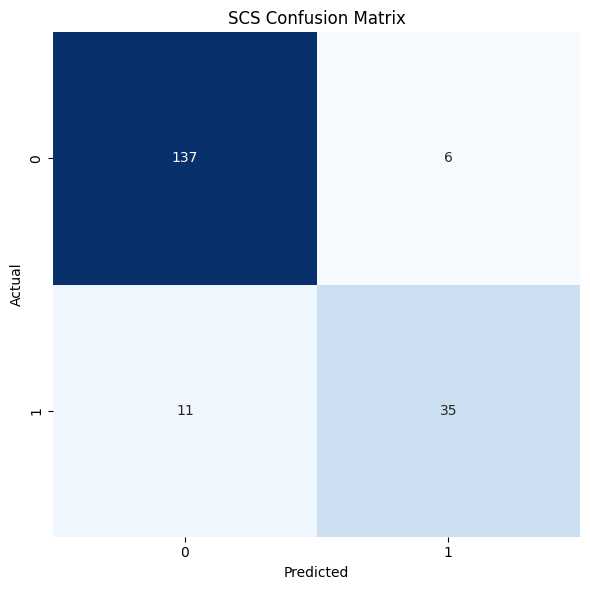

=== Metrics for LNfN ===
Accuracy: 0.7778
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.91      0.83       115
         1.0       0.81      0.57      0.67        74

    accuracy                           0.78       189
   macro avg       0.79      0.74      0.75       189
weighted avg       0.78      0.78      0.77       189

Confusion Matrix:
 [[105  10]
 [ 32  42]] 



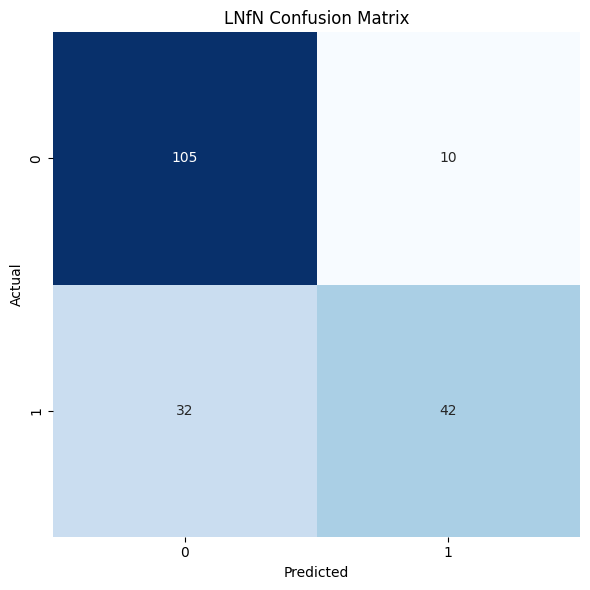

=== Metrics for RNfN ===
Accuracy: 0.8148
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       117
         1.0       0.84      0.64      0.72        72

    accuracy                           0.81       189
   macro avg       0.82      0.78      0.79       189
weighted avg       0.82      0.81      0.81       189

Confusion Matrix:
 [[108   9]
 [ 26  46]] 



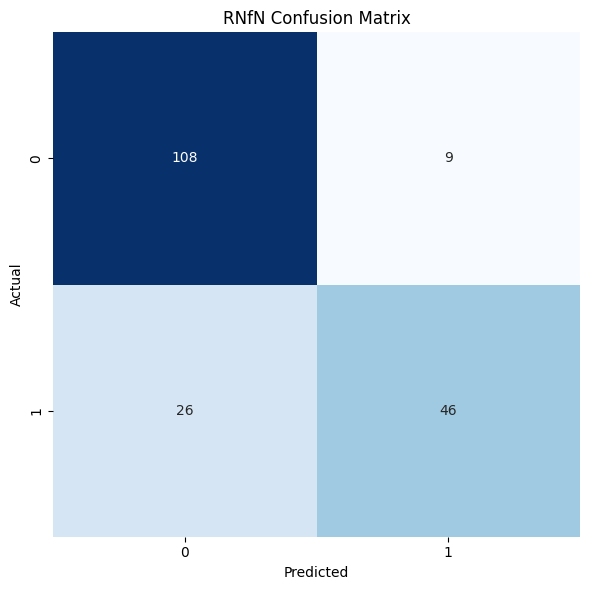

Temporary config file removed.


In [26]:
import tempfile

# Load the default configuration from 'config.yml'
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

# Update the training parameters using the extracted folder parameters
config["training"]["model_arch"] = folder_params["model_arch"]
config["training"]["classification_mode"] = folder_params["classification_mode"]
config["training"]["selected_tensor_folder"] = folder_params["selected_tensor_folder"]
config["training"]["batch_size"] = folder_params["batch_size"]
config["training"]["num_epochs"] = folder_params["num_epochs"]
config["training"]["learning_rate"] = folder_params["learning_rate"]

# Save the updated configuration to a temporary file (so original config.yml is not modified)
temp_config_path = os.path.join(tempfile.gettempdir(), "temp_config.yml")
with open(temp_config_path, "w") as f:
    yaml.dump(config, f, default_flow_style=False)
print("Temporary config file created at:", temp_config_path)

# Define the path to the best model file
best_model_path = os.path.join(MODEL_FOLDER, "best_model.pth") # or best_val_loss_model.pth / "best_model.pth"
if os.path.exists(best_model_path):
    print("Best model found:", best_model_path)
else:
    raise FileNotFoundError(f"Best model file not found at: {best_model_path}")

# Import the evaluate_model function from the evaluation module
from src.evaluate.evaluate_model import evaluate_model

# Evaluate the model using the temporary configuration file
evaluate_model(model_path=best_model_path, config_path=temp_config_path, split="test")

# Optionally, remove the temporary config file after evaluation
os.remove(temp_config_path)
print("Temporary config file removed.")

Temporary config file created at: /tmp/temp_config.yml
Best model found: models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507/best_model.pth
[INFO] Loading model from models/resnet3d_18_multi_binary_target_window_128x128_5D_B2A2_16_10_0.001_0.5_20250313_102507/best_model.pth using arch=resnet3d_18


Evaluating on test set:   0%|          | 0/13 [00:00<?, ?it/s]

[INFO] Evaluation Completed.

=== Metrics for SCS ===
Accuracy: 0.9101
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       143
         1.0       0.85      0.76      0.80        46

    accuracy                           0.91       189
   macro avg       0.89      0.86      0.87       189
weighted avg       0.91      0.91      0.91       189

Confusion Matrix:
 [[137   6]
 [ 11  35]] 



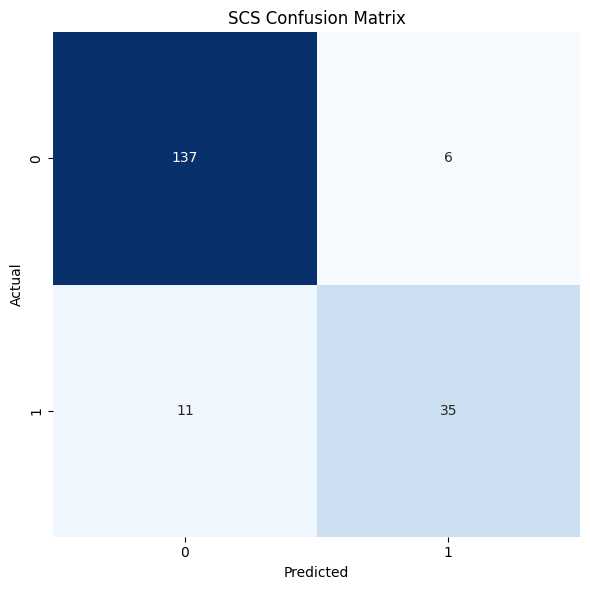

=== Metrics for LNfN ===
Accuracy: 0.7778
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.91      0.83       115
         1.0       0.81      0.57      0.67        74

    accuracy                           0.78       189
   macro avg       0.79      0.74      0.75       189
weighted avg       0.78      0.78      0.77       189

Confusion Matrix:
 [[105  10]
 [ 32  42]] 



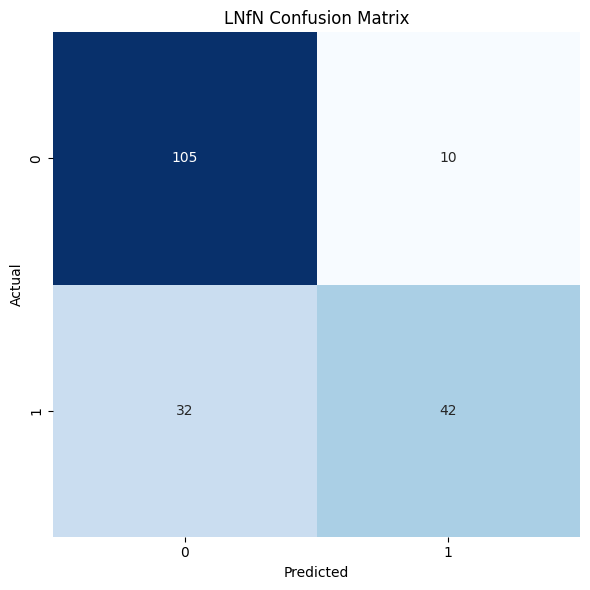

=== Metrics for RNfN ===
Accuracy: 0.8148
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       117
         1.0       0.84      0.64      0.72        72

    accuracy                           0.81       189
   macro avg       0.82      0.78      0.79       189
weighted avg       0.82      0.81      0.81       189

Confusion Matrix:
 [[108   9]
 [ 26  46]] 



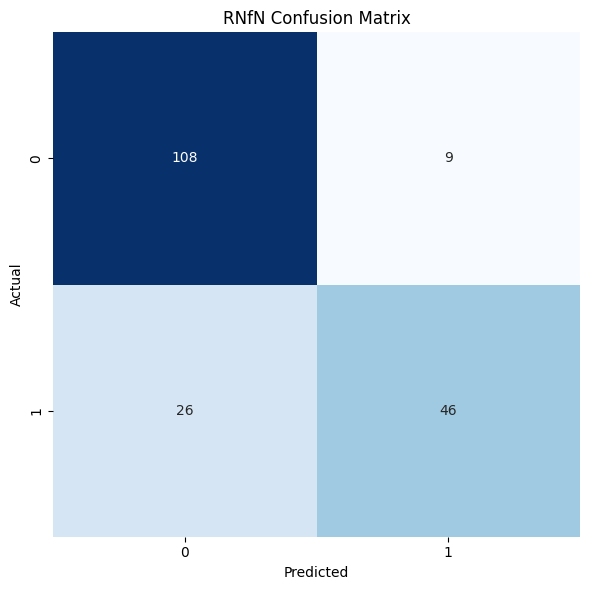

Temporary config file removed.


In [27]:
import tempfile

# Load the default configuration from 'config.yml'
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

# Update the training parameters using the extracted folder parameters
config["training"]["model_arch"] = folder_params["model_arch"]
config["training"]["classification_mode"] = folder_params["classification_mode"]
config["training"]["selected_tensor_folder"] = folder_params["selected_tensor_folder"]
config["training"]["batch_size"] = folder_params["batch_size"]
config["training"]["num_epochs"] = folder_params["num_epochs"]
config["training"]["learning_rate"] = folder_params["learning_rate"]

# Save the updated configuration to a temporary file (so original config.yml is not modified)
temp_config_path = os.path.join(tempfile.gettempdir(), "temp_config.yml")
with open(temp_config_path, "w") as f:
    yaml.dump(config, f, default_flow_style=False)
print("Temporary config file created at:", temp_config_path)

# Define the path to the best model file
best_model_path = os.path.join(MODEL_FOLDER, "best_model.pth") # or best_val_loss_model.pth / "best_model.pth"
if os.path.exists(best_model_path):
    print("Best model found:", best_model_path)
else:
    raise FileNotFoundError(f"Best model file not found at: {best_model_path}")

# Import the evaluate_model function from the evaluation module
from src.evaluate.evaluate_model import evaluate_model

# Evaluate the model using the temporary configuration file
evaluate_model(model_path=best_model_path, config_path=temp_config_path, split="test")

# Optionally, remove the temporary config file after evaluation
os.remove(temp_config_path)
print("Temporary config file removed.")